## 客戶流失預測分析報告

在金融產業中，客戶流失對營運造成重大影響。透過資料驅動的分析方法，本研究目標為：

- 預測信用卡客戶是否會流失（Churn）
- 探索與流失相關的重要行為與屬性特徵
- 建立可用於客戶關係管理的預測模型

此研究可協助銀行提升客戶留存率、優化行銷策略並降低營運風險。

【資料集】
* [BankChurners.csv](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers)

#### <font color=#0000FF>安裝主要的模組</font>

In [1]:
# -*- coding: utf-8 -*-
from platform import python_version
import os, time, glob, socket
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency, ttest_ind
import seaborn as sns

print("【日期時間】{}".format(time.strftime("%Y/%m/%d %H:%M:%S")))
print("【工作目錄】{}".format(os.getcwd()))
print("【主機名稱】{} ({})".format(socket.gethostname(),socket.gethostbyname(socket.gethostname())))
print("【Python】{}".format(python_version()))
print("【sklearn】{}".format(sklearn.__version__))

# %autosave 120

【日期時間】2025/05/05 11:31:05
【工作目錄】d:\NTPU_class\ml\code
【主機名稱】MSI (10.20.70.63)
【Python】3.10.5
【sklearn】1.6.1


In [2]:
from matplotlib.font_manager import FontProperties  
winfont01 = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12) 
winfont02 = FontProperties(fname=r"c:\windows\fonts\kaiu.ttf", size=12) 

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定字型為微軟正黑體
# plt.rcParams['axes.unicode_minus'] = False                # 解決負號顯示問題

# macfont = FontProperties(fname="/Library/Fonts/Arial Unicode.ttf", size=10) 

#### <font color='blue'>資料讀取</font>

In [3]:
df = pd.read_csv(r"C:\Data\BankChurners.csv")
print(df.columns)

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')


#### <font color='blue'>EDA 檢定: 類別(Chi-Test) / 連續(T-Test)</font>

In [73]:
# 設定應變數: Churn.
df['Churn'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)
print(df['Churn'].value_counts())
# 類別與連續變數
categorical_vars = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
numerical_vars = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                  'Total_Relationship_Count', 'Months_Inactive_12_mon',
                  'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                  'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Ct',
                  'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

# 類別變數卡方檢定
chi_results = {}
for col in categorical_vars:
    table = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, _ = chi2_contingency(table)
    chi_results[col] = p

# 連續變數 T 檢定
t_test_results = {}
for col in numerical_vars:
    churn_1 = df[df['Churn'] == 1][col]
    churn_0 = df[df['Churn'] == 0][col]
    _, p = ttest_ind(churn_1, churn_0, equal_var=False)
    t_test_results[col] = p

# 結果表格
chi_df = pd.DataFrame(chi_results.items(), columns=["CategoricalVariables", "P-Value"]).sort_values(by="P-Value")
chi_df["P-Value"] = chi_df["P-Value"].round(3)
chi_df['Significantly'] = chi_df['P-Value'].apply(lambda x: "Y" if x <= 0.05 else "N")

ttest_df = pd.DataFrame(t_test_results.items(), columns=["NumericalVariables", "P-Value"]).sort_values(by="P-Value")
ttest_df['P-Value'] = ttest_df['P-Value'].round(3)
ttest_df['Significantly'] = ttest_df['P-Value'].apply(lambda x: "Y" if x <= 0.05 else "N")
print("【Chi-Test】")
print(chi_df)
print("【T-Test】")
print(ttest_df)

0    8500
1    1627
Name: Churn, dtype: int64
【Chi-Test】
  CategoricalVariables  P-Value Significantly
0               Gender    0.000             Y
3      Income_Category    0.025             Y
1      Education_Level    0.051             N
2       Marital_Status    0.109             N
4        Card_Category    0.525             N
【T-Test】
          NumericalVariables  P-Value Significantly
10            Total_Trans_Ct    0.000             Y
11       Total_Ct_Chng_Q4_Q1    0.000             Y
7        Total_Revolving_Bal    0.000             Y
9            Total_Trans_Amt    0.000             Y
5      Contacts_Count_12_mon    0.000             Y
12     Avg_Utilization_Ratio    0.000             Y
4     Months_Inactive_12_mon    0.000             Y
3   Total_Relationship_Count    0.000             Y
6               Credit_Limit    0.016             Y
1            Dependent_count    0.053             N
0               Customer_Age    0.058             N
2             Months_on_book    0.

#### <font color='blue'>EDA 圖表繪製: 類別(百分比堆疊圖) / 連續(盒狀圖)</font>

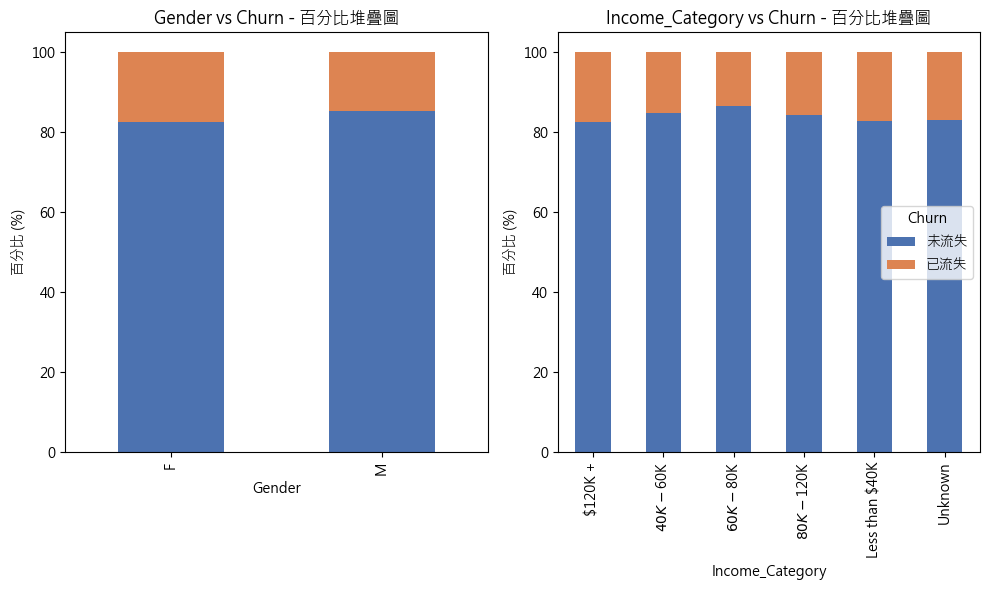

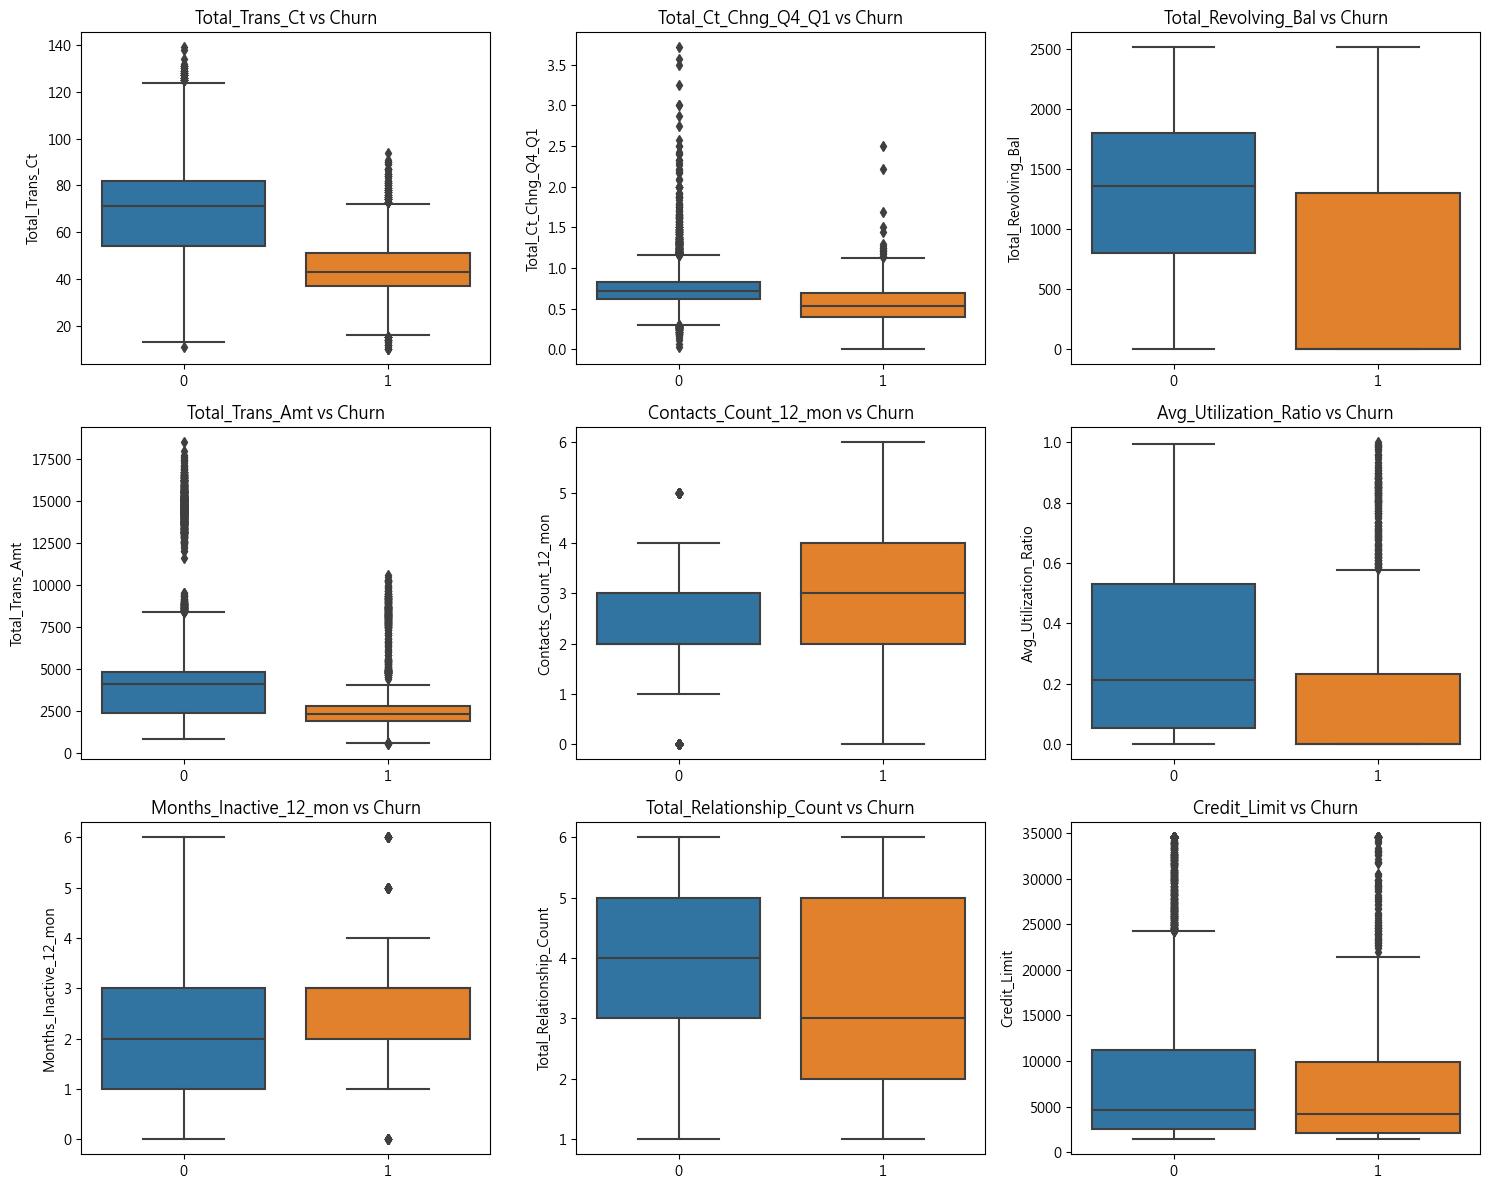

In [6]:
cat_list = chi_df[chi_df['Significantly'] == 'Y']['CategoricalVariables'].to_list()
num_list = ttest_df[ttest_df['Significantly'] == 'Y']['NumericalVariables'].to_list()

from statsmodels.graphics.mosaicplot import mosaic
# 顏色對應 Churn: 0=藍, 1=橘
color_map = {0: '#4c72b0', 1: '#dd8452'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))  # 調整高度方便閱讀

for idx, col in enumerate(cat_list):
    crosstab = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    crosstab = crosstab[[0, 1]]  # 確保順序
    crosstab.plot(kind='bar', stacked=True,
                  color=[color_map[0], color_map[1]],
                  ax=axs[idx],
                  legend=False)  # 避免重複圖例
    plt.legend(title='Churn', labels=['未流失', '已流失'], loc='center right')
    axs[idx].set_title(f'{col} vs Churn - 百分比堆疊圖')
    axs[idx].set_ylabel('百分比 (%)')

# 單獨設定圖例於最後
handles, labels = axs[0].get_legend_handles_labels()


plt.tight_layout()
plt.show()

# 建立 3x3 子圖
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axs = axs.flatten()  # 攤平成一維 list 方便索引

# 連續變數盒狀圖
for i, col in enumerate(num_list):
    sns.boxplot(data=df, x='Churn', y=col, ax=axs[i])
    axs[i].set_title(f'{col} vs Churn')
    axs[i].set_xlabel('')  # 可以視情況隱藏標籤
    axs[i].set_ylabel(col)

# 排版美化
plt.tight_layout()
plt.show()

#### <font color='blue'>資料清洗: 類別(One-Hot Encoding) / 連續(MixMaxScaler)</font>

In [61]:
# Label
y = df["Churn"].to_numpy()

# 類別 Features
X_categorical = pd.get_dummies(df[categorical_vars],
                                drop_first=False, # One-Hot encoding
                                dtype=np.int16)
# 連續 Features
scaler = MinMaxScaler()  # 標準化X 的單位, 可用來比較變數重要度.
X_numerical = pd.DataFrame(scaler.fit_transform(df[numerical_vars]), 
                           columns=numerical_vars)

# 合併 Features
X_std = pd.concat([X_categorical, X_numerical], axis=1).to_numpy()

print(X_categorical.shape)
print(X_numerical.shape)
print(X_std.shape)

(10127, 23)
(10127, 13)
(10127, 36)


#### <font color='blue'>模型實驗</font>

In [78]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
model1 = LogisticRegression(penalty='l2',           # 懲罰項
                            dual=False,
                            tol=0.0001,             # tolerence 容忍門檻值
                            max_iter=1000,           # 迭代次數(跑幾次)
                            C=1.0,                  # lambda 值
                            random_state=None,      # seed
                            solver='lbfgs',         # 最佳化器，如何去找出來? 等下再說
                            multi_class='auto',     # 
                            verbose=0,              # 顯示訊息量的多寡
                            warm_start=False, 
                            n_jobs=1)           # cores 電腦 cpu 的核心數

model2 = KNeighborsClassifier(n_neighbors=5,           # kNN 的 k
                              weights='uniform',
                              p=2,                     # p=2 : euclidean_distance
                              metric='minkowski',
                              n_jobs=-1 )

model3 = DecisionTreeClassifier(criterion='gini',         # gini : CART, entropy : C4.5/C5.0
                               max_depth=None)

model4 = GaussianNB()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y  # 分層抽樣
                                                    )

In [85]:
from sklearn.metrics import f1_score

models = [model1, model2, model3, model4]  # 分類器s

for model in models:
    print(f"--- {model.__class__.__name__} ---")
    model.fit(X_train, y_train)
    print(f"train acc : {model.score(X_train, y_train):.2%}")
    print(f"test acc : {model.score(X_test, y_test):.2%}")
    print(f"train f1 : {f1_score(model.predict(X_train), y_train, average='binary'):.2%}")
    print(f"test f1 : {f1_score(model.predict(X_test), y_test, average='binary'):.2%}")

--- LogisticRegression ---
train acc : 90.64%
test acc : 89.98%
train f1 : 65.45%
test f1 : 61.48%
--- KNeighborsClassifier ---
train acc : 89.12%
test acc : 85.24%
train f1 : 53.99%
test f1 : 33.70%
--- DecisionTreeClassifier ---
train acc : 100.00%
test acc : 92.94%
train f1 : 100.00%
test f1 : 77.27%
--- GaussianNB ---
train acc : 88.52%
test acc : 86.82%
train f1 : 63.21%
test f1 : 57.55%


In [13]:
# AutoML 的概念, 把所有的都跑過, 找出Accuracy 最大值.
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
models = [LogisticRegression(solver=solver).fit(X_train, y_train) for solver in solvers]
scores = [model.score(X_train, y_train) for model in models]
print(scores)
print(f"最大值的index : {np.argmax(scores)}")
print(f"最大值的solver : {solvers[np.argmax(scores)]}")

[0.859714928732183, 0.8589647411852963, 0.8600900225056264, 0.859714928732183, 0.859714928732183, 0.859714928732183]
最大值的index : 2
最大值的solver : newton-cg


In [15]:
# Confusion Matrix. 混淆矩陣.

y_train_hat = model.predict(X_train)

mtx = pd.crosstab(index=y_train,            # actual
                  columns=y_train_hat,      # predicted
                  rownames=["Actual"],
                  colnames=["Predicted"],)
mtx

Predicted,0,1
Actual,,
0,2268,16
1,358,24


In [16]:
print(np.array(mtx).trace())           # 對角線相加
print(np.array(mtx).sum())             # 全部相加
print(np.array(mtx).trace() / np.array(mtx).sum())       # accuracy

2292
2666
0.859714928732183


#### <font color='blue'>香菇的分類(有毒性p、可食用e)</font>
- [Logistic Regression for Classifying Mushrooms](https://www.kaggle.com/sowbal/logistic-regression-for-classifying-mushrooms) <font color=#FF0000>【★★★★★】</font>

In [18]:
fname = 'C:/Data/PyMLData/mushrooms.csv'
data = pd.read_csv(fname)
data.head(3)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [45]:
# 【方法一】探究 X 使用 LabelEncoder : 學理上，這是錯誤的
fname = 'C:/Data/PyMLData/mushrooms.csv'
data = pd.read_csv(fname)

In [46]:
encoder = LabelEncoder()

for col in data.columns[1:] :
    data[col] = encoder.fit_transform(data[col])

X = data.drop(["class"], axis=1, inplace=False).to_numpy()
y = data["class"].to_numpy()
X

array([[5, 2, 4, ..., 2, 3, 5],
       [5, 2, 9, ..., 3, 2, 1],
       [0, 2, 8, ..., 3, 2, 3],
       ...,
       [2, 2, 4, ..., 0, 1, 2],
       [3, 3, 4, ..., 7, 4, 2],
       [5, 2, 4, ..., 4, 1, 2]])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [48]:
model = LogisticRegression(penalty='l2',           # 懲罰項
                           dual=False,
                           tol=0.0001,             # tolerence 容忍門檻值
                           max_iter=1000,           # 迭代次數(跑幾次)
                           C=1.0,                  # lambda 值
                           random_state=None,      # seed
                           solver='lbfgs',         # 最佳化器，如何去找出來? 等下再說
                           multi_class='auto',     # 
                           verbose=0,              # 顯示訊息量的多寡
                           warm_start=False, 
                           n_jobs=-1,)           # cores 電腦 cpu 的核心數
model.fit(X_train, y_train)
print(f"train acc : {model.score(X_train, y_train):.3%}")
print(f"test acc : {model.score(X_test, y_test):.3%}")

train acc : 95.138%
test acc : 94.769%


In [53]:
# 【方法二】探究 X 使用 One-Hot Encode : 學理上，這是正確的
fname = 'C:/Data/PyMLData/mushrooms.csv'
data = pd.read_csv(fname)

In [54]:
X = pd.get_dummies(data.drop(["class"], axis=1, inplace=False), drop_first=False, dtype=np.int16).to_numpy()
y = data["class"].to_numpy()
X

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [56]:
model = LogisticRegression(penalty='l2',           # 懲罰項
                           dual=False,
                           tol=0.0001,             # tolerence 容忍門檻值
                           max_iter=100,           # 迭代次數(跑幾次)
                           C=1.0,                  # lambda 值
                           random_state=None,      # seed
                           solver='lbfgs',         # 最佳化器，如何去找出來? 等下再說
                           multi_class='auto',     # 
                           verbose=0,              # 顯示訊息量的多寡
                           warm_start=False, 
                           n_jobs=-1,)           # cores 電腦 cpu 的核心數
model.fit(X_train, y_train)
print(f"train acc : {model.score(X_train, y_train):.3%}")
print(f"test acc : {model.score(X_test, y_test):.3%}")

train acc : 100.000%
test acc : 100.000%


In [57]:
# 儲存已訓練模型.

import joblib
joblib.dump(value=model, filename=r"C:\Data\model.job", compress=0,)

['C:\\Data\\model.job']

In [58]:
# 讀取模型 部屬.

model_2 = joblib.load(filename=r"C:\Data\model.job")

In [59]:
y_test_hat = model_2.predict(X_test)

df = pd.DataFrame(X_test)
df["predicted"] = y_test_hat
print(f"test acc : {model_2.score(X_test, y_test):.3%}")

test acc : 100.000%


### <font color=#0000FF>【wdbc威斯康辛乳腺癌診斷資料】</font>
威斯康辛乳腺癌診斷資料 : <https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data>

1. ID number
2. Diagnosis (M = malignant, B = benign) : （M =惡性，B =良性）

3-32 , Ten real-valued features are computed for each cell nucleus:
3. radius (mean of distances from center to points on the perimeter) : 半徑（從中心到外圍點的距離的平均值）
4. texture (standard deviation of gray-scale values) : 紋理（灰度值的標準偏差）
5. perimeter : 周長
6. area : 面積
7. smoothness (local variation in radius lengths) : 平滑度（半徑長度的局部變化）
8. compactness (perimeter^2 / area - 1.0) : 密實度（周長^ 2 /面積-1.0）
9. concavity (severity of concave portions of the contour) : 凹度（輪廓凹部的嚴重程度）
10. concave points (number of concave portions of the contour) : 凹點（輪廓的凹入部分的數量）
11. symmetry : 對稱
12. fractal dimension ("coastline approximation" - 1) : 分形維數（“海岸線近似”-1）



In [ ]:
uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
colnames = ["id", "diagnosis", "radius_mean", "texture_mean", "perimeter_mean", 
           "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave_points_mean",
           "symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se",
           "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se",
           "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst",
           "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst",
           "symmetry_worst", "fractal_dimension_worst"]
data = pd.read_csv(uri, header=None,names=colnames)
print(data.shape)
print(data.columns)

### <font color=#FF0000>Multinomial Logistic Regression</font>
- [Multinomial Logistic Regression With Python](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/?fbclid=IwAR0zip9tm11LtsigbwtmePHMjRtwS7v4tHjr8ZIvNpgATnuX6M9xpHpxROc) <font color=#FF0000>【★★★★★】</font>
    - Binomial Logistic Regression: Standard logistic regression that predicts a binomial probability (i.e. for two classes) for each input example.
    - Multinomial Logistic Regression: Modified version of logistic regression that predicts a multinomial probability (i.e. more than two classes) for each input example.

#### <font color='red'>以下這個資料集有三種類別可以使用於此</font>
- [sklearn.datasets.load_wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) : 三個類別

In [ ]:
dataset = sklearn.datasets.load_wine()
X = dataset.data
y = dataset.target
print(X.shape, y.shape)
print(Counter(y))
print(dataset.feature_names)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')